In [ ]:
%matplotlib inline



# How to plot topomaps the way EEGLAB does

If you have previous EEGLAB experience you may have noticed that topomaps
(topoplots) generated using MNE-Python look a little different from those
created in EEGLAB. If you prefer the EEGLAB style this example will show you
how to calculate head sphere origin and radius to obtain EEGLAB-like channel
layout in MNE.


In [1]:
# Authors: Mikołaj Magnuski <mmagnuski@swps.edu.pl>
#
# License: BSD (3-clause)
import numpy as np
from matplotlib import pyplot as plt

import mne


print(__doc__)

Automatically created module for IPython interactive environment


## Create fake data

First we will create a simple evoked object with a single timepoint using
biosemi 10-20 channel layout.



In [2]:
biosemi_montage = mne.channels.make_standard_montage('biosemi64')
n_channels = len(biosemi_montage.ch_names)
fake_info = mne.create_info(ch_names=biosemi_montage.ch_names, sfreq=250.,
                            ch_types='eeg')

rng = np.random.RandomState(0)
data = rng.normal(size=(n_channels, 1)) * 1e-6
fake_evoked = mne.EvokedArray(data, fake_info)
fake_evoked.set_montage(biosemi_montage)

<Evoked | '' (average, N=1), [0, 0] sec, 64 ch, ~180 kB>

## Calculate sphere origin and radius

EEGLAB plots head outline at the level where the head circumference is
measured
in the 10-20 system (a line going through Fpz, T8/T4, Oz and T7/T3 channels).
MNE-Python places the head outline lower on the z dimension, at the level of
the anatomical landmarks :term:`LPA, RPA, and NAS <fiducial point>`.
Therefore to use the EEGLAB layout we
have to move the origin of the reference sphere (a sphere that is used as a
reference when projecting channel locations to a 2d plane) a few centimeters
up.

Instead of approximating this position by eye, as we did in `the sensor
locations tutorial <tut-sensor-locations>`, here we will calculate it using
the position of Fpz, T8, Oz and T7 channels available in our montage.



In [3]:
# first we obtain the 3d positions of selected channels
check_ch = ['Oz', 'Fpz', 'T7', 'T8']
ch_idx = [fake_evoked.ch_names.index(ch) for ch in check_ch]
pos = np.stack([fake_evoked.info['chs'][idx]['loc'][:3] for idx in ch_idx])

# now we calculate the radius from T7 and T8 x position
# (we could use Oz and Fpz y positions as well)
radius = np.abs(pos[[2, 3], 0]).mean()

# then we obtain the x, y, z sphere center this way:
# x: x position of the Oz channel (should be very close to 0)
# y: y position of the T8 channel (should be very close to 0 too)
# z: average z position of Oz, Fpz, T7 and T8 (their z position should be the
#    the same, so we could also use just one of these channels), it should be
#    positive and somewhere around `0.03` (3 cm)
x = pos[0, 0]
y = pos[-1, 1]
z = pos[:, -1].mean()

# lets print the values we got:
print([f'{v:0.5f}' for v in [x, y, z, radius]])

['0.00000', '0.00000', '0.03683', '0.09494']


## Compare MNE and EEGLAB channel layout

We already have the required x, y, z sphere center and its radius — we can
use these values passing them to the ``sphere`` argument of many
topo-plotting functions (by passing ``sphere=(x, y, z, radius)``).



Text(0.5, 1.0, 'EEGLAB channel projection')

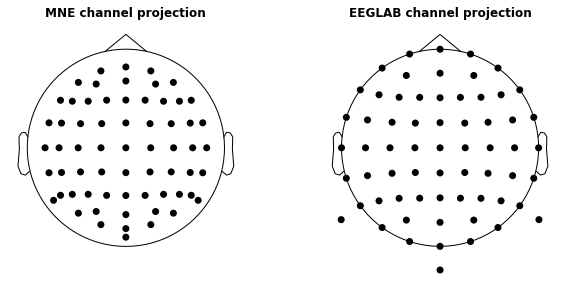

In [4]:
# create a two-panel figure with some space for the titles at the top
fig, ax = plt.subplots(ncols=2, figsize=(8, 4), gridspec_kw=dict(top=0.9),
                       sharex=True, sharey=True)

# we plot the channel positions with default sphere - the mne way
fake_evoked.plot_sensors(axes=ax[0], show=False)

# in the second panel we plot the positions using the EEGLAB reference sphere
fake_evoked.plot_sensors(sphere=(x, y, z, radius), axes=ax[1], show=False)

# add titles
fig.texts[0].remove()
ax[0].set_title('MNE channel projection', fontweight='bold')
ax[1].set_title('EEGLAB channel projection', fontweight='bold')

## Topomaps (topoplots)

As the last step we do the same, but plotting the topomaps. These will not
be particularly interesting as they will show random data but hopefully you
will see the difference.



Text(0.5, 1.0, 'EEGLAB')

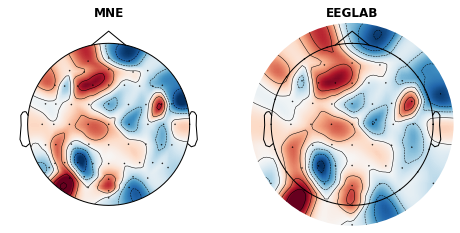

In [18]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 4), gridspec_kw=dict(top=0.9),
                       sharex=True, sharey=True)

mne.viz.plot_topomap(fake_evoked.data[:, 0], fake_evoked.info, axes=ax[0],
                     show=False)
mne.viz.plot_topomap(fake_evoked.data[:, 0], fake_evoked.info, axes=ax[1],
                     show=False, sphere=(x, y, z, radius))

# add titles
ax[0].set_title('MNE', fontweight='bold')
ax[1].set_title('EEGLAB', fontweight='bold')

In [7]:
type(fake_evoked.info)

mne.io.meas_info.Info

In [16]:
fake_evoked.data[:, 0].shape

(64,)

In [19]:
fake_info = mne.create_info(ch_names=biosemi_montage.ch_names, sfreq=250.,
                            ch_types='eeg')
fake_info.

<Info | 7 non-empty values
 bads: []
 ch_names: Fp1, AF7, AF3, F1, F3, F5, F7, FT7, FC5, FC3, FC1, C1, C3, C5, ...
 chs: 64 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: unspecified
 nchan: 64
 projs: []
 sfreq: 250.0 Hz
>